In [ ]:
!pip install -U tensorflow opencv-python


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 620.7/620.7 MB 845.3 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 115.4 MB/s eta 0:00:00
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.19.0
    Uninstalling tensorboard-2.19.0:
      Successfully uninstalled tensorboard-2.19.0
  Attempting uninstall: tensorflow
    Found existing installation: tensorflow 2.19.0
    Uninstalling tensorflow-2.19.0:
      Successfully uninstalled tensorflow-2.19.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow-decision-forests 1.12.0 requires tensorflow==2.19.0, but you have tensorflow 2.20.0 which is incompatible.
tensorflow-text 2.19.0 requires tensorflow<2.20,>=2.19.0, but you have tensorflow 2.20.0 which is incompatible.
tf-keras 2.19.0 requires tensorflow<2.20,>=2.19, but you have tensorflow 2.20.0 which is i

In [ ]:
import cv2
import os
import random
import numpy as np
from matplotlib import pyplot as plt

In [ ]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer, Conv2D, Dense, MaxPooling2D, Input, Flatten
import tensorflow as tf

In [ ]:
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

In [ ]:
POS_PATH = os.path.join('data', 'positive')
NEG_PATH = os.path.join('data', 'negative')
ANC_PATH = os.path.join('data', 'anchor')

In [ ]:
os.makedirs(POS_PATH)
os.makedirs(NEG_PATH)
os.makedirs(ANC_PATH)

In [ ]:

import json, os

kaggle_creds = {
    "username": "omprakashmourya",
    "key": "my_kaggle_api"
}

os.makedirs("/root/.kaggle", exist_ok=True)
with open("/root/.kaggle/kaggle.json", "w") as f:
    json.dump(kaggle_creds, f)

%chmod 600 /root/.kaggle/kaggle.json


In [8]:
!kaggle datasets download -d jessicali9530/lfw-dataset

Dataset URL: https://www.kaggle.com/datasets/jessicali9530/lfw-dataset
License(s): other
 70% 79.0M/112M [00:00<00:00, 424MB/s]
100% 112M/112M [00:00<00:00, 405MB/s] 


In [9]:
import zipfile
zip_ref = zipfile.ZipFile('/content/lfw-dataset.zip', 'r')
zip_ref.extractall('/content')
zip_ref.close()

In [11]:
!find /content/lfw-deepfunneled/lfw-deepfunneled -type f \( -iname "*.jpg" -o -iname "*.jpeg" -o -iname "*.png" \) -exec mv {} /content/data/negative/ \;


In [ ]:
import uuid

In [13]:

os.path.join(ANC_PATH, '{}.jpg'.format(uuid.uuid1()))

'data/anchor/8dc22ba4-e00d-11f0-b300-0242ac1c000c.jpg'

In [ ]:
cap = cv2.VideoCapture(0)
while cap.isOpened():
    ret, frame = cap.read()

    frame = frame[120:120+250,200:200+250, :]

    if cv2.waitKey(1) & 0XFF == ord('a'):
        imgname = os.path.join(ANC_PATH, '{}.jpg'.format(uuid.uuid1()))
        cv2.imwrite(imgname, frame)

    if cv2.waitKey(1) & 0XFF == ord('p'):
        imgname = os.path.join(POS_PATH, '{}.jpg'.format(uuid.uuid1()))
        cv2.imwrite(imgname, frame)

    cv2.imshow('Image Collection', frame)

    if cv2.waitKey(1) & 0XFF == ord('q'):
        break

cap.release()
cv2.destroyAllWindows()

In [15]:
!rm -rf /content/data/positive
!rm -rf /content/data/anchor

In [16]:
zip_ref = zipfile.ZipFile('/content/anchor.zip', 'r')
zip_ref.extractall('/content/data')
zip_ref.close()

In [17]:
zip_ref = zipfile.ZipFile('/content/positive.zip', 'r')
zip_ref.extractall('/content/data')
zip_ref.close()

In [18]:
def data_aug(img):
    data = []
    for i in range(9):
        img = tf.image.stateless_random_brightness(img, max_delta=0.02, seed=(1,2))
        img = tf.image.stateless_random_contrast(img, lower=0.6, upper=1, seed=(1,3))
        img = tf.image.stateless_random_flip_left_right(img, seed=(np.random.randint(100),np.random.randint(100)))
        img = tf.image.stateless_random_jpeg_quality(img, min_jpeg_quality=90, max_jpeg_quality=100, seed=(np.random.randint(100),np.random.randint(100)))
        img = tf.image.stateless_random_saturation(img, lower=0.9,upper=1, seed=(np.random.randint(100),np.random.randint(100)))

        data.append(img)

    return data

In [19]:

img_path = os.path.join(ANC_PATH, '3f7ff047-df42-11f0-baab-1091d123fc48.jpg')
img = cv2.imread(img_path)
augmented_images = data_aug(img)

for image in augmented_images:
    cv2.imwrite(os.path.join(ANC_PATH, '{}.jpg'.format(uuid.uuid1())), image.numpy())

In [20]:
for file_name in os.listdir(os.path.join(POS_PATH)):
    img_path = os.path.join(POS_PATH, file_name)
    img = cv2.imread(img_path)
    augmented_images = data_aug(img)

    for image in augmented_images:
        cv2.imwrite(os.path.join(POS_PATH, '{}.jpg'.format(uuid.uuid1())), image.numpy())

In [21]:
anchor = tf.data.Dataset.list_files(ANC_PATH + '/*.jpg').take(3000)
positive = tf.data.Dataset.list_files(POS_PATH + '/*.jpg').take(3000)
negative = tf.data.Dataset.list_files(NEG_PATH + '/*.jpg').take(3000)

In [22]:
dir_test = anchor.as_numpy_iterator()

In [23]:

print(dir_test.next())

b'data/anchor/3efa6c92-df42-11f0-b7c2-1091d123fc48.jpg'


In [24]:
def preprocess(file_path):

    byte_img = tf.io.read_file(file_path)
    img = tf.io.decode_jpeg(byte_img)

    img = tf.image.resize(img, (100,100))
    img = img / 255.0

    return img

In [25]:
img = preprocess('data/anchor/27c14c96-df41-11f0-88ce-1091d123fc48.jpg')

In [26]:

img.numpy().max()

np.float32(0.8980392)

In [27]:

positives = tf.data.Dataset.zip((anchor, positive, tf.data.Dataset.from_tensor_slices(tf.ones(len(anchor)))))
negatives = tf.data.Dataset.zip((anchor, negative, tf.data.Dataset.from_tensor_slices(tf.zeros(len(anchor)))))
data = positives.concatenate(negatives)

In [28]:

samples = data.as_numpy_iterator()

In [29]:
exampple = samples.next()

In [30]:
exampple

(b'data/anchor/4741cbce-df42-11f0-9f3a-1091d123fc48.jpg',
 b'data/positive/99887fce-e00d-11f0-b300-0242ac1c000c.jpg',
 np.float32(1.0))

In [31]:
def preprocess_twin(input_img, validation_img, label):
    return(preprocess(input_img), preprocess(validation_img), label)

In [32]:
res = preprocess_twin(*exampple)

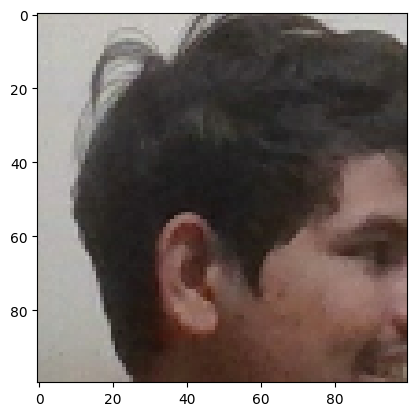

In [33]:

plt.imshow(res[1])

In [34]:
res[2]

np.float32(1.0)

In [35]:
data = data.map(preprocess_twin)
data = data.cache()
data = data.shuffle(buffer_size=10000)

In [36]:
train_data = data.take(round(len(data)*.7))
train_data = train_data.batch(16)
train_data = train_data.prefetch(8)

In [37]:
test_data = data.skip(round(len(data)*.7))
test_data = test_data.take(round(len(data)*.3))
test_data = test_data.batch(16)
test_data = test_data.prefetch(8)

In [38]:
inp = Input(shape=(100,100,3), name='input_image')

In [39]:
c1 = Conv2D(64, (10,10), activation='relu')(inp)

In [40]:
m1 = MaxPooling2D(64, (2,2), padding='same')(c1)

In [41]:
c2 = Conv2D(128, (7,7), activation='relu')(m1)
m2 = MaxPooling2D(64, (2,2), padding='same')(c2)

In [42]:
c3 = Conv2D(128, (4,4), activation='relu')(m2)
m3 = MaxPooling2D(64, (2,2), padding='same')(c3)

In [43]:
c4 = Conv2D(256, (4,4), activation='relu')(m3)
f1 = Flatten()(c4)
d1 = Dense(4096, activation='sigmoid')(f1)

In [44]:
mod = Model(inputs=inp, outputs=d1, name='embedding')

In [45]:
mod.summary()

Model: "embedding"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_image (InputLayer)        │ (None, 100, 100, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 91, 91, 64)     │        19,264 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 46, 46, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 40, 40, 128)    │       401,536 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 20, 20, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 17, 17, 128)    │       262,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 9, 9, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 6, 6, 256)      │       524,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 9216)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 4096)           │    37,752,832 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 38,960,448 (148.62 MB)

 Trainable params: 38,960,448 (148.62 MB)

 Non-trainable params: 0 (0.00 B)

In [46]:
def make_embedding():
    inp = Input(shape=(100,100,3), name='input_image')

    c1 = Conv2D(64, (10,10), activation='relu')(inp)
    m1 = MaxPooling2D(64, (2,2), padding='same')(c1)

    c2 = Conv2D(128, (7,7), activation='relu')(m1)
    m2 = MaxPooling2D(64, (2,2), padding='same')(c2)

    c3 = Conv2D(128, (4,4), activation='relu')(m2)
    m3 = MaxPooling2D(64, (2,2), padding='same')(c3)

    c4 = Conv2D(256, (4,4), activation='relu')(m3)
    f1 = Flatten()(c4)
    d1 = Dense(4096, activation='sigmoid')(f1)


    return Model(inputs=inp, outputs=d1, name='embedding')

In [47]:
embedding = make_embedding()

In [48]:
embedding.summary()

Model: "embedding"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_image (InputLayer)        │ (None, 100, 100, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 91, 91, 64)     │        19,264 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 46, 46, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 40, 40, 128)    │       401,536 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 20, 20, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 17, 17, 128)    │       262,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 9, 9, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 6, 6, 256)      │       524,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 9216)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4096)           │    37,752,832 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 38,960,448 (148.62 MB)

 Trainable params: 38,960,448 (148.62 MB)

 Non-trainable params: 0 (0.00 B)

In [49]:
from tensorflow.keras.layers import Layer

In [50]:
class L1Dist(Layer):

    def __init__(self, **kwargs):
        super().__init__()

    def call(self, inputs):
        input_embedding, validation_embedding = inputs
        return tf.math.abs(input_embedding - validation_embedding)

In [51]:
l1 = L1Dist()

In [53]:
input_image = Input(name='input_img', shape=(100,100,3))
validation_image = Input(name='validation_img', shape=(100,100,3))

In [54]:
inp_embedding = embedding(input_image)
val_embedding = embedding(validation_image)

In [55]:
siamese_layer = L1Dist()

In [56]:
print(type(inp_embedding))
print(inp_embedding)


<class 'keras.src.backend.common.keras_tensor.KerasTensor'>
<KerasTensor shape=(None, 4096), dtype=float32, sparse=False, ragged=False, name=keras_tensor_18>


In [57]:
distances = siamese_layer([inp_embedding, val_embedding])

In [58]:
classifier = Dense(1, activation='sigmoid')(distances)

In [59]:
classifier

<KerasTensor shape=(None, 1), dtype=float32, sparse=False, ragged=False, name=keras_tensor_21>

In [60]:
siamese_network = Model(inputs=[input_image, validation_image], outputs=classifier, name='SiameseNetwork')

In [61]:
siamese_network.summary()

Model: "SiameseNetwork"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_img           │ (None, 100, 100,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ validation_img      │ (None, 100, 100,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding           │ (None, 4096)      │ 38,960,448 │ input_img[0][0],  │
│ (Functional)        │                   │            │ validation_img[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ l1_dist_1 (L1Dist)  │ (None, 4096)      │          0 │ embedding[0][0],  │
│                     │                   │            │ embedding[1][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 1)         │      4,097 │ l1_dist_1[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 38,964,545 (148.64 MB)

 Trainable params: 38,964,545 (148.64 MB)

 Non-trainable params: 0 (0.00 B)

In [62]:
def make_siamese_model():

    input_image = Input(name='input_img', shape=(100,100,3))

    validation_image = Input(name='validation_img', shape=(100,100,3))

    distances = L1Dist(name='distance')([
        embedding(input_image),
        embedding(validation_image)
    ])

    classifier = Dense(1, activation='sigmoid')(distances)

    return Model(inputs=[input_image, validation_image], outputs=classifier, name='SiameseNetwork')

In [63]:
siamese_model = make_siamese_model()

In [64]:
siamese_model.summary()

Model: "SiameseNetwork"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_img           │ (None, 100, 100,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ validation_img      │ (None, 100, 100,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding           │ (None, 4096)      │ 38,960,448 │ input_img[0][0],  │
│ (Functional)        │                   │            │ validation_img[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ l1_dist_2 (L1Dist)  │ (None, 4096)      │          0 │ embedding[2][0],  │
│                     │                   │            │ embedding[3][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 1)         │      4,097 │ l1_dist_2[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 38,964,545 (148.64 MB)

 Trainable params: 38,964,545 (148.64 MB)

 Non-trainable params: 0 (0.00 B)

In [65]:
binary_cross_loss = tf.losses.BinaryCrossentropy()

In [66]:
opt = tf.keras.optimizers.Adam(1e-4)


In [67]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, 'ckpt')
checkpoint = tf.train.Checkpoint(opt=opt, siamese_model=siamese_model)

In [68]:
test_batch = train_data.as_numpy_iterator()

In [69]:
batch_1 = test_batch.next()

In [70]:
X = batch_1[:2]

In [71]:
y = batch_1[2]

In [72]:
y

array([1., 0., 1., 1., 1., 0., 0., 1., 1., 1., 0., 1., 0., 0., 1., 1.],
      dtype=float32)

In [73]:
tf.losses.BinaryCrossentropy??

In [74]:
@tf.function
def train_step(batch):

    with tf.GradientTape() as tape:
        X = batch[:2]
        y = batch[2]

        yhat = siamese_model(X, training=True)
        loss = binary_cross_loss(y, yhat)
    print(loss)

    grad = tape.gradient(loss, siamese_model.trainable_variables)

    opt.apply_gradients(zip(grad, siamese_model.trainable_variables))

    return loss

In [75]:
from tensorflow.keras.metrics import Precision, Recall

In [76]:
def train(data, EPOCHS):
    for epoch in range(1, EPOCHS+1):
        print('\n Epoch {}/{}'.format(epoch, EPOCHS))
        progbar = tf.keras.utils.Progbar(len(data))

        r = Recall()
        p = Precision()

        for idx, batch in enumerate(data):
            loss = train_step(batch)
            yhat = siamese_model.predict(batch[:2])
            r.update_state(batch[2], yhat)
            p.update_state(batch[2], yhat)
            progbar.update(idx+1)
        print(loss.numpy(), r.result().numpy(), p.result().numpy())

        if epoch % 10 == 0:
            checkpoint.save(file_prefix=checkpoint_prefix)

In [77]:
EPOCHS = 50

In [78]:
train(train_data, EPOCHS)


 Epoch 1/50
Tensor("binary_crossentropy/div_no_nan:0", shape=(), dtype=float32)
Tensor("binary_crossentropy/div_no_nan:0", shape=(), dtype=float32)
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 295ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 297ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 290ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 305ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 286ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 292ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 294ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 292ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 290ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 297ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 293ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 298ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 294ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 299ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 298ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 295ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 299ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 289ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 293ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 298ms/s

In [79]:
from tensorflow.keras.metrics import Precision, Recall

In [80]:
test_input, test_val, y_true = test_data.as_numpy_iterator().next()

In [81]:
y_hat = siamese_model.predict([test_input, test_val])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 281ms/step


In [82]:
[1 if prediction > 0.5 else 0 for prediction in y_hat ]

[1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1]

In [83]:
[1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1]

[1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1]

In [84]:
y_true

array([1., 0., 1., 0., 0., 0., 1., 1., 1., 0., 1., 1., 1., 0., 1., 1.],
      dtype=float32)

In [85]:
np.array([1., 1., 1., 0., 1., 1., 0., 0., 1., 0., 0., 0., 0., 1., 0., 1.],
dtype='float64')

array([1., 1., 1., 0., 1., 1., 0., 0., 1., 0., 0., 0., 0., 1., 0., 1.])

In [86]:
m = Recall()

m.update_state(y_true, y_hat)

m.result().numpy()

np.float32(1.0)

In [87]:
m = Precision()

m.update_state(y_true, y_hat)

m.result().numpy()


np.float32(1.0)

In [88]:
r = Recall()
p = Precision()

for test_input, test_val, y_true in test_data.as_numpy_iterator():
    yhat = siamese_model.predict([test_input, test_val])
    r.update_state(y_true, yhat)
    p.update_state(y_true,yhat)

print(r.result().numpy(), p.result().numpy())

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 982ms/step
1.0 1.0


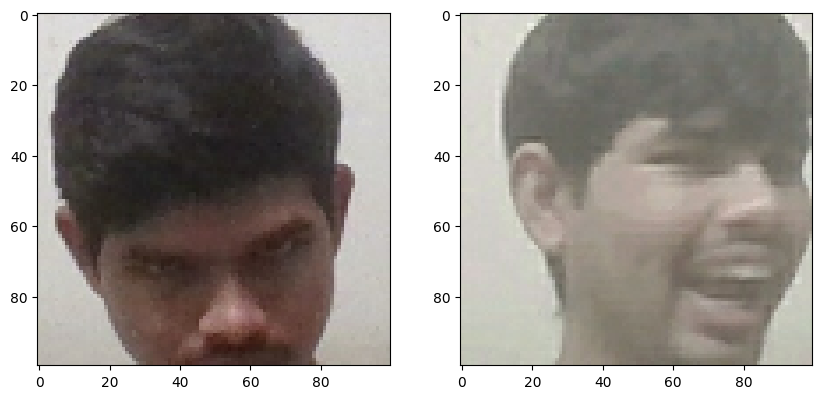

In [89]:
plt.figure(figsize=(10,8))

plt.subplot(1,2,1)
plt.imshow(test_input[0])

plt.subplot(1,2,2)
plt.imshow(test_val[0])

plt.show()

In [90]:
siamese_model.save('siamesemodelv2.h5')

In [91]:
L1Dist

__main__.L1Dist

In [92]:
siamese_model = tf.keras.models.load_model('siamesemodelv2.h5',
                                   custom_objects={'L1Dist':L1Dist, 'BinaryCrossentropy':tf.losses.BinaryCrossentropy})

In [93]:
siamese_model.predict([test_input, test_val])

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 927ms/step


array([[1.0000000e+00],
       [9.9999976e-01],
       [2.2856226e-09]], dtype=float32)

In [94]:
np.array([[2.7295970e-05],
       [8.7373185e-01],
       [1.1476276e-06],
       [9.9997568e-01],
       [9.9490523e-01],
       [2.8164588e-06],
       [2.9260066e-06],
       [1.0000000e+00]], dtype='float32')

array([[2.7295970e-05],
       [8.7373185e-01],
       [1.1476276e-06],
       [9.9997568e-01],
       [9.9490523e-01],
       [2.8164588e-06],
       [2.9260066e-06],
       [1.0000000e+00]], dtype=float32)

In [95]:
siamese_model.summary()


Model: "SiameseNetwork"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_img           │ (None, 100, 100,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ validation_img      │ (None, 100, 100,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding           │ (None, 4096)      │ 38,960,448 │ input_img[0][0],  │
│ (Functional)        │                   │            │ validation_img[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ l1_dist_3 (L1Dist)  │ (None, 4096)      │          0 │ embedding[0][0],  │
│                     │                   │            │ embedding[1][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 1)         │      4,097 │ l1_dist_3[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 38,964,545 (148.64 MB)

 Trainable params: 38,964,545 (148.64 MB)

 Non-trainable params: 0 (0.00 B)

In [99]:
!mkdir -p application_data/input_image application_data/verification_images


In [101]:
import os
import random
import shutil

BASE_DIR = "/content"
POSITIVE_DIR = os.path.join(BASE_DIR, "data/positive")
VERIFICATION_DIR = os.path.join(BASE_DIR, "application_data/verification_images")
INPUT_IMAGE_DIR = os.path.join(BASE_DIR, "application_data/input_image")

all_images = os.listdir(POSITIVE_DIR)
random_images = random.sample(all_images, 50)

for img in random_images:
    src = os.path.join(POSITIVE_DIR, img)
    dst = os.path.join(VERIFICATION_DIR, img)
    shutil.copy(src, dst)

print("Copied 50 random positive images to verification_images")

src_photo = os.path.join(BASE_DIR, "input_image.jpg")
dst_photo = os.path.join(INPUT_IMAGE_DIR, "input_image.jpg")

shutil.copy(src_photo, dst_photo)

print("Copied input_image.jpg to input_image")


Copied 50 random positive images to verification_images
Copied myphoto.jpg to input_image


In [102]:
os.listdir(os.path.join('application_data', 'verification_images'))

['90815662-e00d-11f0-b300-0242ac1c000c.jpg',
 '928441c2-e00d-11f0-b300-0242ac1c000c.jpg',
 'a29807e2-e00d-11f0-b300-0242ac1c000c.jpg',
 'ebc387c7-df41-11f0-95c4-1091d123fc48.jpg',
 'a21b1bc4-e00d-11f0-b300-0242ac1c000c.jpg',
 '722a8a83-df41-11f0-a5a6-1091d123fc48.jpg',
 'ada9abfe-e00d-11f0-b300-0242ac1c000c.jpg',
 'caaaa044-df41-11f0-ab7f-1091d123fc48.jpg',
 'a0bff308-e00d-11f0-b300-0242ac1c000c.jpg',
 'a0502d48-e00d-11f0-b300-0242ac1c000c.jpg',
 'a87329d0-e00d-11f0-b300-0242ac1c000c.jpg',
 'a9bc5fe6-e00d-11f0-b300-0242ac1c000c.jpg',
 'a22a6322-e00d-11f0-b300-0242ac1c000c.jpg',
 'afd4ae6a-e00d-11f0-b300-0242ac1c000c.jpg',
 'ebe6c3b2-df41-11f0-aade-1091d123fc48.jpg',
 'a88328da-e00d-11f0-b300-0242ac1c000c.jpg',
 'a862b3fc-e00d-11f0-b300-0242ac1c000c.jpg',
 'a56db296-e00d-11f0-b300-0242ac1c000c.jpg',
 'b01d5458-e00d-11f0-b300-0242ac1c000c.jpg',
 '98aa0fd2-e00d-11f0-b300-0242ac1c000c.jpg',
 '6016dde2-df41-11f0-9736-1091d123fc48.jpg',
 'a02175c0-e00d-11f0-b300-0242ac1c000c.jpg',
 'a5b290b4

In [103]:
os.path.join('application_data', 'input_image', 'input_image.jpg')

'application_data/input_image/input_image.jpg'

In [104]:
for image in os.listdir(os.path.join('application_data', 'verification_images')):
    validation_img = os.path.join('application_data', 'verification_images', image)
    print(validation_img)

application_data/verification_images/90815662-e00d-11f0-b300-0242ac1c000c.jpg
application_data/verification_images/928441c2-e00d-11f0-b300-0242ac1c000c.jpg
application_data/verification_images/a29807e2-e00d-11f0-b300-0242ac1c000c.jpg
application_data/verification_images/ebc387c7-df41-11f0-95c4-1091d123fc48.jpg
application_data/verification_images/a21b1bc4-e00d-11f0-b300-0242ac1c000c.jpg
application_data/verification_images/722a8a83-df41-11f0-a5a6-1091d123fc48.jpg
application_data/verification_images/ada9abfe-e00d-11f0-b300-0242ac1c000c.jpg
application_data/verification_images/caaaa044-df41-11f0-ab7f-1091d123fc48.jpg
application_data/verification_images/a0bff308-e00d-11f0-b300-0242ac1c000c.jpg
application_data/verification_images/a0502d48-e00d-11f0-b300-0242ac1c000c.jpg
application_data/verification_images/a87329d0-e00d-11f0-b300-0242ac1c000c.jpg
application_data/verification_images/a9bc5fe6-e00d-11f0-b300-0242ac1c000c.jpg
application_data/verification_images/a22a6322-e00d-11f0-b300-024

In [108]:
def verify(model, detection_threshold, verification_threshold):
    results = []
    for image in os.listdir(os.path.join('application_data', 'verification_images')):
        input_img = preprocess(os.path.join('application_data', 'input_image', 'input_image.jpg'))
        validation_img = preprocess(os.path.join('application_data', 'verification_images', image))

        result = model.predict(list(np.expand_dims([input_img, validation_img], axis=1)))
        results.append(result)

    detection = np.sum(np.array(results) > detection_threshold)

    verification = detection / len(os.listdir(os.path.join('application_data', 'verification_images')))
    verified = verification > verification_threshold

    return results, verified

In [111]:
from IPython.display import display, Javascript
from google.colab.output import eval_js
from base64 import b64decode

def capture_image(filename='application_data/input_image/input_image.jpg'):
    js = Javascript('''
        async function capture() {
            const div = document.createElement('div');
            const video = document.createElement('video');
            const btn = document.createElement('button');
            btn.textContent = 'Capture';
            div.appendChild(video);
            div.appendChild(btn);
            document.body.appendChild(div);

            const stream = await navigator.mediaDevices.getUserMedia({video: true});
            video.srcObject = stream;
            await video.play();

            await new Promise(resolve => btn.onclick = resolve);

            const canvas = document.createElement('canvas');
            canvas.width = video.videoWidth;
            canvas.height = video.videoHeight;
            canvas.getContext('2d').drawImage(video, 0, 0);

            stream.getTracks().forEach(track => track.stop());
            div.remove();

            return canvas.toDataURL('image/jpeg');
        }
        capture();
    ''')
    display(js)
    data = eval_js('capture()')
    binary = b64decode(data.split(',')[1])

    with open(filename, 'wb') as f:
        f.write(binary)

    print("Image captured and saved.")


In [113]:
capture_image()


<IPython.core.display.Javascript object>

Image captured and saved.


In [109]:
cap = cv2.VideoCapture(4)
while cap.isOpened():
    ret, frame = cap.read()
    frame = frame[120:120+250,200:200+250, :]

    cv2.imshow('Verification', frame)

    if cv2.waitKey(10) & 0xFF == ord('v'):



        cv2.imwrite(os.path.join('application_data', 'input_image', 'input_image.jpg'), frame)
        results, verified = verify(siamese_model, 0.5, 0.5)
        print(verified)

    if cv2.waitKey(10) & 0xFF == ord('q'):
        break
cap.release()
cv2.destroyAllWindows()

In [115]:
results, verified = verify(siamese_model, 0.5, 0.5)

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━

In [116]:
np.sum(np.squeeze(results) > 0.9)

np.int64(36)

In [117]:
results

[array([[0.9999975]], dtype=float32),
 array([[0.99999726]], dtype=float32),
 array([[0.00044573]], dtype=float32),
 array([[5.8222843e-10]], dtype=float32),
 array([[0.9998858]], dtype=float32),
 array([[2.5894035e-06]], dtype=float32),
 array([[0.10123654]], dtype=float32),
 array([[0.52926177]], dtype=float32),
 array([[0.99998724]], dtype=float32),
 array([[0.997595]], dtype=float32),
 array([[0.9995349]], dtype=float32),
 array([[0.9965519]], dtype=float32),
 array([[0.999895]], dtype=float32),
 array([[0.99994373]], dtype=float32),
 array([[3.483296e-10]], dtype=float32),
 array([[0.9999654]], dtype=float32),
 array([[3.2648181e-06]], dtype=float32),
 array([[0.99998426]], dtype=float32),
 array([[0.9998894]], dtype=float32),
 array([[0.9998826]], dtype=float32),
 array([[0.00086509]], dtype=float32),
 array([[0.98804325]], dtype=float32),
 array([[0.01982849]], dtype=float32),
 array([[0.9999938]], dtype=float32),
 array([[0.9999838]], dtype=float32),
 array([[0.9994923]], dtype